# Lab 6: Essay Writer

## Setup and Imports

In this section, we're building a more complex project: an AI Essay Writer. We'll start by setting up our environment and importing the necessary libraries. We're using Amazon Bedrock and Anthropic's Claude model, so our imports reflect that.
We're setting up logging, configuring Bedrock, and retrieving our Tavily API key. Tavily is a research tool we'll use to gather information for our essays. Make sure you have your Tavily API key stored securely.

A few requirements for the UI that we build at the end:

1. Add your tavily ai key to the `.env` file.

2. Pay attention that you run on LangGraph 0.0.53.

3. Run the helper.py from the CLI and open the web browser to step through the graph or run it in the notebook directly!


In [4]:
from dotenv import load_dotenv
import os
import sys
import json, re
import pprint
import boto3
from botocore.client import Config
import warnings

warnings.filterwarnings("ignore")
import logging

# import local modules
dir_current = os.path.abspath("")
dir_parent = os.path.dirname(dir_current)
if dir_parent not in sys.path:
    sys.path.insert(0, dir_parent)
from utils import utils

# Set basic configs
logger = utils.set_logger()
pp = utils.set_pretty_printer()

# Load environment variables from .env file or Secret Manager
_ = load_dotenv("../.env")
aws_region = os.getenv("AWS_REGION")
tavily_ai_api_key = utils.get_tavily_api("TAVILY_API_KEY", aws_region)

# Set bedrock configs
bedrock_config = Config(
    connect_timeout=120, read_timeout=120, retries={"max_attempts": 0}
)

# Create a bedrock runtime client
bedrock_rt = boto3.client(
    "bedrock-runtime", region_name=aws_region, config=bedrock_config
)


[2025-10-07 15:14:42,122] p30926 {utils.py:46} INFO - TAVILY_API_KEY variable correctly retrieved from the .env file.


## Defining the Agent State

Now, let's define our agent's state. This is more complex than in previous lessons because our essay writer has multiple steps and needs to keep track of various pieces of information.

We're creating a TypedDict called AgentState. It includes:

- task: The essay topic or question
- plan: The outline of the essay
- draft: The current version of the essay
- critique: Feedback on the current draft
- content: Research information from Tavily
- revision_number: How many revisions we've made
- max_revisions: The maximum number of revisions we want to make

These elements will help us manage the essay writing process and know when to stop revising.


In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    AIMessage,
    ChatMessage,
)

memory = MemorySaver()

In [6]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

## Setting up the Model

We're using Anthropic's Claude model via Amazon Bedrock. We're setting it up with a temperature of 0 for more consistent outputs. The model we're using is claude-3-haiku, which is well-suited for this task.


In [7]:
from langchain_aws import ChatBedrockConverse

model = ChatBedrockConverse(
    client=bedrock_rt,
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
)

/home/workshop/langgraph-agents-with-amazon-bedrock/.venv/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `ChatBedrockConverse` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


## Defining Prompts

Our essay writer uses several prompts for different stages of the process:

1. **PLAN_PROMPT**: This instructs the model to create an essay outline.
2. **WRITER_PROMPT**: This guides the model in writing the essay based on the plan and research.
3. **REFLECTION_PROMPT**: This tells the model how to critique the essay.
4. **RESEARCH_PLAN_PROMPT** and **RESEARCH_CRITIQUE_PROMPT**: These help generate search queries for our research step.

Each prompt is carefully crafted to guide the model in performing its specific task within the essay writing process.


In [8]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [9]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------
<content>
{content}
</content>"""

In [10]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [11]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

In [12]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

### Excursion on strucutred output generation with Anthropic Models:

Take a look at the prompts above.

- Do they follow the prompting guide of Anthropic?
- Do you think you could get more consistent outputs by requesting an answer structure that would look something like this, e.g. for the REFLECTION_PROMPT:

```xml
<answer>
  <overall_assessment>
    <strengths>
      <strength_point></strength_point>
      <strength_point></strength_point>
    </strengths>
    <weaknesses>
      <weakness_point></weakness_point>
      <weakness_point></weakness_point>
    </weaknesses>
  </overall_assessment>

...

  <style_and_language>
    <clarity>
      <comment></comment>
      <recommendation></recommendation>
    </clarity>
    <tone>
      <comment></comment>
      <recommendation></recommendation>
    </tone>
    <grammar_and_mechanics>
      <comment></comment>
      <recommendation></recommendation>
    </grammar_and_mechanics>
  </style_and_language>

  <length_assessment>
    <comment></comment>
    <recommendation></recommendation>
  </length_assessment>

  <conclusion>
    <overall_recommendation></overall_recommendation>
    <priority_improvements>
      <improvement></improvement>
      <improvement></improvement>
    </priority_improvements>
  </conclusion>
</answer>
```

- What would the advantage and disadvantage of such a structure be?
- Ask yourself, if the extra tokens are worth it? When should you invest in a detailed, token intensive prompt, vs. a more freeform one?

- How would you parse this output?

**Hint:**
You can combine XMLOutput-Parser from LangChain and PyDantic models.

For reference, below you can find how to use the XMLOutput parser, without any dependencies on methods like `.with_structured_output(...)`, which is a very recent addition to langchain.


In [13]:
from langchain_core.output_parsers.xml import XMLOutputParser

# Create the XMLOutputParser with our Pydantic model
essay_critique_parser = XMLOutputParser()

# Example usage
xml_string = """
<answer>
  <overall_assessment>
    <strengths>
      <strength_point>Clear thesis statement</strength_point>
      <strength_point>Well-structured paragraphs</strength_point>
    </strengths>
    <weaknesses>
      <weakness_point>Lack of detailed examples</weakness_point>
      <weakness_point>Some grammatical errors</weakness_point>
    </weaknesses>
  </overall_assessment>
  <content_evaluation>
    <depth_of_analysis>
      <comment>The analysis lacks depth in some areas.</comment>
      <recommendation>Expand on key points with more detailed explanations.</recommendation>
    </depth_of_analysis>
    <argument_quality>
      <comment>Arguments are logical but could be stronger.</comment>
      <recommendation>Provide more evidence to support your claims.</recommendation>
    </argument_quality>
    <evidence_use>
      <comment>Limited use of supporting evidence.</comment>
      <recommendation>Incorporate more relevant examples and data.</recommendation>
    </evidence_use>
  </content_evaluation>
  <structure_and_organization>
    <comment>The essay has a clear structure but transitions could be improved.</comment>
    <recommendation>Work on smoother transitions between paragraphs.</recommendation>
  </structure_and_organization>
  <style_and_language>
    <clarity>
      <comment>Writing is generally clear but some sentences are convoluted.</comment>
      <recommendation>Simplify complex sentences for better readability.</recommendation>
    </clarity>
    <tone>
      <comment>The tone is appropriate for an academic essay.</comment>
      <recommendation>Maintain this formal tone throughout.</recommendation>
    </tone>
    <grammar_and_mechanics>
      <comment>There are a few grammatical errors and typos.</comment>
      <recommendation>Proofread carefully to eliminate these errors.</recommendation>
    </grammar_and_mechanics>
  </style_and_language>
  <length_assessment>
    <comment>The essay meets the required length.</comment>
    <recommendation>No changes needed in terms of length.</recommendation>
  </length_assessment>
  <conclusion>
    <overall_recommendation>This is a solid essay that could be improved with more depth and better proofreading.</overall_recommendation>
    <priority_improvements>
      <improvement>Deepen analysis with more detailed explanations and examples.</improvement>
      <improvement>Carefully proofread to eliminate grammatical errors and typos.</improvement>
    </priority_improvements>
  </conclusion>
</answer>
"""

# Parse the XML string
parsed_critique = essay_critique_parser.parse(xml_string)
parsed_critique

{'answer': [{'overall_assessment': [{'strengths': [{'strength_point': 'Clear thesis statement'},
      {'strength_point': 'Well-structured paragraphs'}]},
    {'weaknesses': [{'weakness_point': 'Lack of detailed examples'},
      {'weakness_point': 'Some grammatical errors'}]}]},
  {'content_evaluation': [{'depth_of_analysis': [{'comment': 'The analysis lacks depth in some areas.'},
      {'recommendation': 'Expand on key points with more detailed explanations.'}]},
    {'argument_quality': [{'comment': 'Arguments are logical but could be stronger.'},
      {'recommendation': 'Provide more evidence to support your claims.'}]},
    {'evidence_use': [{'comment': 'Limited use of supporting evidence.'},
      {'recommendation': 'Incorporate more relevant examples and data.'}]}]},
  {'structure_and_organization': [{'comment': 'The essay has a clear structure but transitions could be improved.'},
    {'recommendation': 'Work on smoother transitions between paragraphs.'}]},
  {'style_and_lang

However, we can also use `.with_structured_output` to get the answer we need!


In [14]:
from langchain_aws import ChatBedrock
from langchain_core.pydantic_v1 import BaseModel, Field


class StructuredOutput(BaseModel):
    title: str = Field(..., description="The title of the response")
    content: str = Field(..., description="The main content of the response")
    summary: str = Field(..., description="A brief summary of the content")


llm = ChatBedrock(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    model_kwargs={"temperature": 0},
)

structured_llm = llm.with_structured_output(StructuredOutput)

response = structured_llm.invoke("Tell me about artificial intelligence")
response

StructuredOutput(title='Artificial Intelligence', content='Artificial intelligence (AI) refers to the development of computer systems and software capable of performing tasks that typically require human intelligence, such as learning, problem-solving, decision-making, and perception. The goal of AI is to create systems that can mimic or exceed human cognitive abilities.\n\nSome key aspects of AI include:\n\n- Machine learning - The ability of computer systems to learn and improve from experience without being explicitly programmed.\n- Natural language processing - The ability to understand, interpret, and generate human language.\n- Computer vision - The ability to identify and process images and videos in the same way that humans do.\n- Robotics - The development of machines that can perform physical tasks, often in place of or to assist humans.\n\nAI has a wide range of applications, including personal digital assistants, autonomous vehicles, medical diagnosis, financial analysis, a

In [15]:
print(response.title)

Artificial Intelligence


In [16]:
structured_llm = llm.with_structured_output(
    StructuredOutput, method="xml_mode"
)  # try xml_mode
response = structured_llm.invoke("Tell me about artificial intelligence")
print(f"The title:\t{response.title}\n")
response

The title:	Artificial Intelligence



StructuredOutput(title='Artificial Intelligence', content='Artificial intelligence (AI) refers to the development of computer systems and software capable of performing tasks that typically require human intelligence, such as learning, problem-solving, decision-making, and perception. AI systems can be designed to mimic various cognitive functions of the human mind, including reasoning, learning, and adaptation.\n\nSome key aspects of AI include:\n\n- Machine learning - The ability of AI systems to learn and improve from experience without being explicitly programmed.\n- Natural language processing - The ability to understand, interpret, and generate human language.\n- Computer vision - The ability to identify and process images and videos in the same way that human vision does.\n- Robotics - The development of machines that can perform physical actions and tasks.\n\nAI has a wide range of applications, from personal digital assistants and recommendation systems to autonomous vehicles 

In [17]:
from langchain_core.pydantic_v1 import BaseModel


class Queries(BaseModel):
    queries: List[str]

### Setting up Tavily Client

We're using the Tavily API for research. We import the TavilyClient and initialize it with our API key. This will allow us to perform web searches to gather information for our essays.


In [18]:
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=tavily_ai_api_key)

## Defining Node Functions

Now we're creating the individual components of our essay writing process. Each function represents a node in our graph:

1. plan_node: Creates the essay outline.
2. research_plan_node: Generates search queries and fetches information based on the plan.
3. generation_node: Writes the essay draft.
4. reflection_node: Critiques the current draft.
5. research_critique_node: Performs additional research based on the critique.
6. should_continue: Decides whether to continue revising or stop.

Each of these functions interacts with our Claude model and updates the agent's state accordingly.


In [19]:
def plan_node(state: AgentState):
    messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
    response = model.invoke(messages)
    return {"plan": response.content}

In [20]:
from typing import List
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import json


class Queries(BaseModel):
    queries: List[str] = Field(description="List of research queries")


def research_plan_node(state: AgentState):
    # Set up the Pydantic output parser
    parser = PydanticOutputParser(pydantic_object=Queries)

    # Create a prompt template with format instructions
    prompt = PromptTemplate(
        template="Generate research queries based on the given task.\n{format_instructions}\nTask: {task}\n",
        input_variables=["task"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Use the model with the new prompt and parser
    queries_output = model.invoke(prompt.format_prompt(task=state["task"]))

    # Extract the content from the AIMessage
    queries_text = queries_output.content

    # Extract the JSON string from the content
    json_start = queries_text.find("{")
    json_end = queries_text.rfind("}") + 1
    json_str = queries_text[json_start:json_end]

    # Parse the JSON string
    queries_dict = json.loads(json_str)

    # Create a Queries object from the parsed JSON
    parsed_queries = Queries(**queries_dict)

    content = state["content"] or []
    for q in parsed_queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [21]:
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [22]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [23]:
def research_critique_node(state: AgentState):
    # Set up the Pydantic output parser
    parser = PydanticOutputParser(pydantic_object=Queries)

    # Create a prompt template with format instructions
    prompt = PromptTemplate(
        template="Generate research queries based on the given critique.\n{format_instructions}\nCritique: {critique}\n",
        input_variables=["critique"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Use the model with the new prompt and parser
    queries_output = model.invoke(prompt.format_prompt(critique=state["critique"]))

    # Extract the content from the AIMessage
    queries_text = queries_output.content

    # Extract the JSON string from the content
    json_start = queries_text.find("{")
    json_end = queries_text.rfind("}") + 1
    json_str = queries_text[json_start:json_end]

    # Parse the JSON string
    queries_dict = json.loads(json_str)

    # Create a Queries object from the parsed JSON
    parsed_queries = Queries(**queries_dict)

    content = state["content"] or []
    for q in parsed_queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [24]:
    def should_continue(state):
        if state["revision_number"] > state["max_revisions"]:
            return END
        return "reflect"

## Building the Graph

With our nodes defined, we can now build our graph. We're using LangGraph's StateGraph to create a flow for our essay writing process. We add each node to the graph, set the entry point to the planner, and define the edges between nodes.

The key part here is the conditional edge after the generate node. It uses our should_continue function to decide whether to reflect and revise, or to end the process.


In [25]:
builder = StateGraph(AgentState)

In [26]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [27]:
builder.set_entry_point("planner")

In [28]:
builder.add_conditional_edges(
    "generate", should_continue, {END: END, "reflect": "reflect"}
)

In [29]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [30]:
graph = builder.compile(checkpointer=memory)

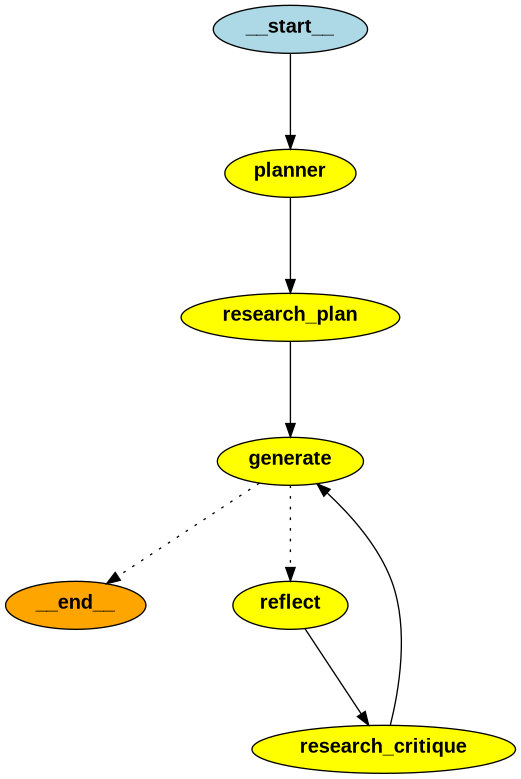

In [31]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

## Running the Graph

To test our essay writer, we're using the graph.stream method. This allows us to see each step of the process as it happens. We're asking it to write an essay on the difference between LangChain and LangSmith, with a maximum of two revisions.

As it runs, you'll see outputs from each node, showing you how the essay evolves through the planning, research, writing, and revision stages.


In [32]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream(
    {
        "task": "what is the difference between langchain and langsmith",
        "max_revisions": 2,
        "revision_number": 1,
    },
    thread,
):
    print(s)

{'planner': {'plan': "Here is a high-level outline for an essay comparing LangChain and LangSmith:\n\nI. Introduction\n   A. Brief overview of LangChain and LangSmith as two prominent open-source frameworks for building applications with large language models (LLMs)\n   B. Thesis statement: While LangChain and LangSmith share some similarities, they have distinct approaches, features, and use cases that make them suitable for different types of projects.\n\nII. Overview of LangChain\n   A. Description of LangChain\n      1. Purpose and goals of the framework\n      2. Key features and components\n         a. Agents\n         b. Chains\n         c. Prompts\n         d. Memory\n   B. Strengths of LangChain\n      1. Modular and flexible architecture\n      2. Support for a wide range of LLMs and other AI models\n      3. Emphasis on building complex, multi-step applications\n\nIII. Overview of LangSmith\n   A. Description of LangSmith\n      1. Purpose and goals of the framework\n      2

## Essay Writer Interface

Finally, lets use a simple GUI using Gradio to make it easy to interact with our essay writer. 

**IMPORTANT NOTE**: To use Gradio within the Amazon SageMaker Code Editor, the app needs to be launched in `shared=True` mode, which creates a public link. Review the [Security and File Access](https://www.gradio.app/guides/sharing-your-app#security-and-file-access) to make sure you understand the security implications.

This GUI allows you to input an essay topic, generate the essay, and see the results of each step in the process. You can also interrupt the process after each step, view the current state of the essay, and even modify the topic or plan if you want to guide the essay in a different direction.

This GUI makes it easy to experiment with the essay writer and see how changes to the input or the process affect the final output.

And that concludes our AI Essay Writer project! You now have a complex, multi-step AI agent that can research, write, and refine essays on a wide range of topics. This project demonstrates how you can combine different AI and API services to create a powerful, practical application.


In [33]:
#set magic variables to allow for a reload when changing code without restarting the kernel
%load_ext autoreload
%autoreload 2

import gradio as gr
from helper import ewriter, writer_gui

MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://7f6a0bc0bd6f030b0a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Result   

![Agent](../assets/lab6_7.png)
![Agent](../assets/lab6_8.png)
![Agent](../assets/lab6_9.png)
![Agent](../assets/lab6_10.png)
![Agent](../assets/lab6_11.png)
![Agent](../assets/lab6_12.png)
![Agent](../assets/lab6_13.png)

## Exercise - Rewrite the Essay writers prompts and parsers


#### Instead of just “Write an outline”, you should ask Claude to return explicit XML.

In [34]:
PLAN_PROMPT = """
You are an expert academic assistant. Please generate a structured outline for an essay on the topic below.

Topic:
{topic}

Return your answer in the following XML format:

<outline>
  <introduction></introduction>
  <main_points>
    <point></point>
    <point></point>
    <point></point>
  </main_points>
  <conclusion></conclusion>
</outline>
"""
# 👉 Goal: Claude returns XML outline → easy to parse with XMLOutputParser

#### Instead of just telling him to “write the best essay” → we asked Claude to write the assignment in a clear 3-part structure.

In [35]:
WRITER_PROMPT = """
You are an essay assistant tasked with writing an excellent, well-structured essay based on the topic and outline provided.
Use the research content below to inform your writing. The essay should have a clear introduction, a structured body, and a thoughtful conclusion.

Research Content:
<content>
{content}
</content>

Return your essay in this XML format:

<essay>
  <introduction></introduction>
  <body>
    <paragraph></paragraph>
    <paragraph></paragraph>
    <paragraph></paragraph>
  </body>
  <conclusion></conclusion>
</essay>
"""


#### Instead of asking Claude to write a freehand comment, we force it to follow a clear schema (like the “Excursion” section in the lab):

In [36]:
REFLECTION_PROMPT = """
You are a teacher grading an essay submission. Generate structured critique and recommendations for the user's submission.

Essay:
{essay}

Return your feedback in the following XML structure:

<answer>
  <overall_assessment>
    <strengths>
      <strength_point></strength_point>
      <strength_point></strength_point>
    </strengths>
    <weaknesses>
      <weakness_point></weakness_point>
      <weakness_point></weakness_point>
    </weaknesses>
  </overall_assessment>

  <style_and_language>
    <clarity>
      <comment></comment>
      <recommendation></recommendation>
    </clarity>
    <tone>
      <comment></comment>
      <recommendation></recommendation>
    </tone>
    <grammar_and_mechanics>
      <comment></comment>
      <recommendation></recommendation>
    </grammar_and_mechanics>
  </style_and_language>

  <length_assessment>
    <comment></comment>
    <recommendation></recommendation>
  </length_assessment>

  <conclusion>
    <overall_recommendation></overall_recommendation>
    <priority_improvements>
      <improvement></improvement>
      <improvement></improvement>
    </priority_improvements>
  </conclusion>
</answer>
"""


### Parse

In [37]:
from langchain.output_parsers.xml import XMLOutputParser
from pydantic import BaseModel
from typing import List

class Outline(BaseModel):
    introduction: str
    main_points: List[str]
    conclusion: str

plan_parser = XMLOutputParser(pydantic_object=Outline)


In [38]:
class Essay(BaseModel):
    introduction: str
    body: List[str]
    conclusion: str

essay_parser = XMLOutputParser(pydantic_object=Essay)


In [39]:
class Critique(BaseModel):
    strengths: List[str]
    weaknesses: List[str]
    clarity_comment: str
    clarity_recommendation: str
    tone_comment: str
    tone_recommendation: str
    grammar_comment: str
    grammar_recommendation: str
    overall_recommendation: str
    priority_improvements: List[str]

critique_parser = XMLOutputParser(pydantic_object=Critique)
